# Part 1 - Data Analysing
## Chapter 5 - Fractionally Differentiated Features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

### 5.1 Generate a time series from an IID Gaussian random process. This is a memoryless, stationary series:

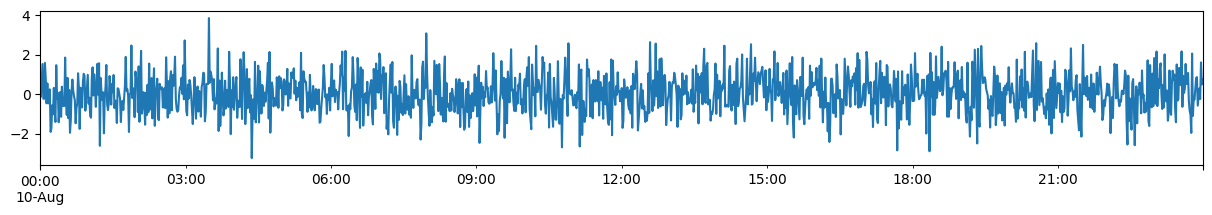

In [3]:
np.random.seed(42)

series = pd.Series(np.random.randn(24 * 60), index=pd.date_range("00:00:00", "23:59:00", freq="1min"))
series.plot(figsize=(15, 2))
None

#### 5.1 (a) Compute the ADF statistic on this series. What is the p-value?

In [4]:
_, p_value, *_ = adfuller(series)
print(f"ADF p value: {p_value}")

ADF p value: 0.0


#### 5.1 (b) Compute the cumulative sum of the observations. This is a non-stationary series without memory.

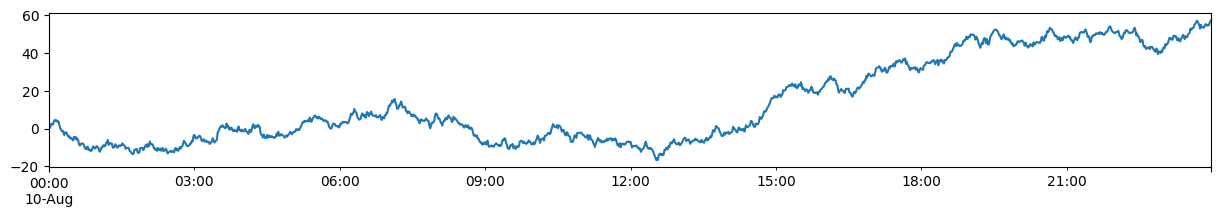

In [5]:
cum_series = series.cumsum()
cum_series.plot(figsize=(15, 2))
None

##### 5.1 (b) i. What is the order of integration of this cumulative series?
 > Order of Integration refers to the number of differencing operations needed to make a time series stationary
 The order integration is 1 because it will  take us back to the IId gaussian random process that we start with.
 
##### 5.1 (b) ii. Compute the ADF statistic on this series. What is the p-value?


In [6]:
for order in range(5):
    diff_ = np.diff(cum_series, order)
    _, p_value, *_ = adfuller(diff_)
    print(f"For order of difference {order} the ADF p value: {p_value}")
    if p_value < 0.05:
        print(f"Order Integration is {order}.")
        break

For order of difference 0 the ADF p value: 0.9742207677843584
For order of difference 1 the ADF p value: 0.0
Order Integration is 1.


#### 5.1 (c) Differentiate the series twice. What is the p-value of this over-differentiated series?

In [7]:
diff_ = np.diff(cum_series, 2)
_, p_value, *_ = adfuller(diff_)
print(f"For order of difference 2 the ADF p value: {p_value}")

For order of difference 2 the ADF p value: 5.035754538046198e-24


### 5.2 Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

<Axes: >

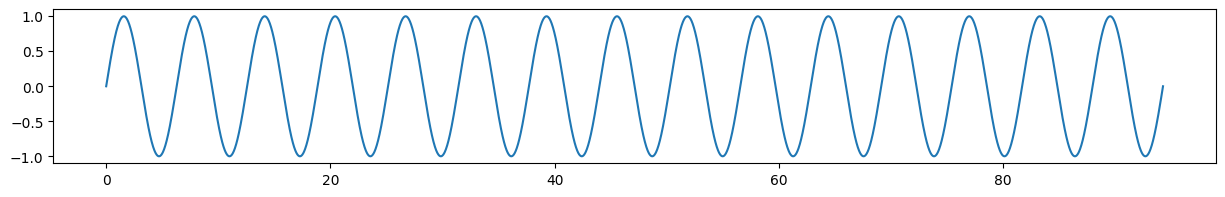

In [17]:
x = np.linspace(0, 30 * np.pi, 5_000)
series = pd.Series(np.sin(x), dtype=float, index=x)
series.plot(figsize=(15, 2))

#### 5.2 (a) Compute the ADF statistic on this series. What is the p-value?

In [18]:
_, p_value, *_ = adfuller(series)
print(f"ADF p value: {p_value}")

ADF p value: 0.0


#### 5.2 (b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

<Axes: >

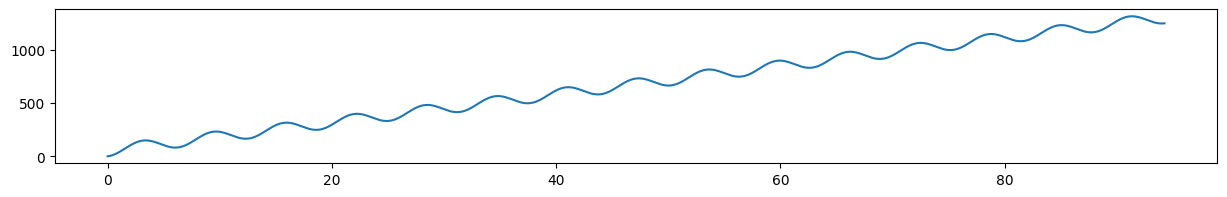

In [28]:
shift = 0.25
series = pd.Series(np.sin(x) + shift, dtype=float, index=x, name="close")
cum_series = series.cumsum()
cum_series.plot(figsize=(15, 2))

##### 5.2 (b) i. Compute the ADF statistic on this series. What is the p-value?

In [29]:
_, p_value, *_ = adfuller(cum_series)
print(f"ADF p value: {p_value}")

ADF p value: 1.0


##### 5.2 (b) ii. Apply an expanding window fracdiff, with $\tau$ = 1E − 2. For what minimum d value do you get a p-value below 5%?

In [30]:
from afml.data_analyst.fractionally_differentiated_features import frac_diff_expanding_window

for d in np.linspace(0, 2, 101):
    differentiated_series_df = frac_diff_expanding_window(pd.DataFrame(cum_series), d, tau=1e-2)
    adf_result = adfuller(differentiated_series_df.dropna().values.squeeze())
    if adf_result[1] < 0.05:
        print(f'Minimum d with p-value < 5%: {d}')
        break


Minimum d with p-value < 5%: 0.02


##### 5.2 (b) iii. Apply FFD, with $\tau$ = 1E−5. For what minimum d value do you get a p-value below 5%?

In [31]:
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

for d in np.linspace(0, 2, 101):
    differentiated_series_df = frac_diff_ffd(pd.DataFrame(cum_series), d, tau=1e-5)
    adf_result = adfuller(differentiated_series_df.dropna().values.squeeze())
    if adf_result[1] < 0.05:
        print(f'Minimum d with p-value < 5%: {d}')
        break

Minimum d with p-value < 5%: 1.0


Seems like FFD doesn't works so well 
Test other taus

In [118]:
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

for tau in [10 ** (-i) for i in range(2, 5)]:
    for d in np.linspace(0, 2, 51):
        differentiated_series_df = frac_diff_ffd(pd.DataFrame(cum_series), d, tau=tau)
        adf_result = adfuller(differentiated_series_df.dropna().values.squeeze())
        if adf_result[1] < 0.05:
            print(f'For tau = 1e{np.log10(tau)} Minimum d with p-value < 5%: {d}')
            break

For tau = 1e-2.0 Minimum d with p-value < 5%: 1.0
For tau = 1e-3.0 Minimum d with p-value < 5%: 1.0
For tau = 1e-4.0 Minimum d with p-value < 5%: 1.0


### 5.3 Take the series from exercise 5.2 (b):
#### Fit the series to a sine function. What is the R-squared?

R-squared for cumulative series: 0.004130455606127237


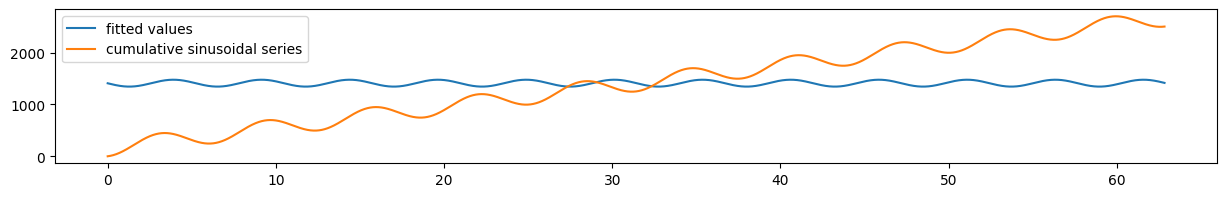

In [119]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score


# Define the sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset


params, _ = curve_fit(sine_function, x, cum_series)  # type: ignore
fitted_values = sine_function(x, *params)
plt.figure(figsize=(15, 2))
plt.plot(x, fitted_values, label='fitted values')
plt.plot(x, cum_series, label='cumulative sinusoidal series')
plt.legend(loc='best')
r_squared_original = r2_score(cum_series, fitted_values)

print(f'R-squared for cumulative series: {r_squared_original}')


#### 5.3 (b) Apply FFD(d=1). Fit the series to a sine function. What is the R-squared?

R-squared for cumulative series: 0.9999999999999951


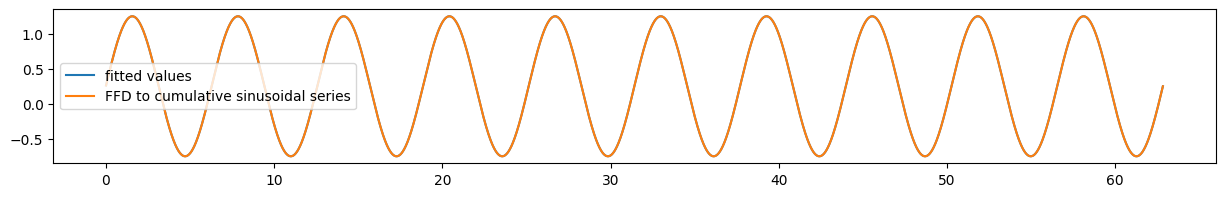

In [120]:
res = frac_diff_ffd(pd.DataFrame({'cum_series': cum_series}), d=1, tau=1e-5)
ffd_res = res['cum_series'].values
ffd_x = x[-len(ffd_res):]

params, _ = curve_fit(sine_function, ffd_x, ffd_res)
fitted_values = sine_function(ffd_x, *params)
plt.figure(figsize=(15, 2))
plt.plot(ffd_x, fitted_values, label='fitted values')
plt.plot(ffd_x, ffd_res, label='FFD to cumulative sinusoidal series')
plt.legend(loc='best')

r_squared_original = r2_score(ffd_res, fitted_values)
print(f'R-squared for cumulative series: {r_squared_original}')

#### 5.3 (c) What value of d maximizes the R-squared of a sinusoidal fit on FFD(d). Why?

Max R-squared for cumulative series with FFD(d=2.0) = 1.0


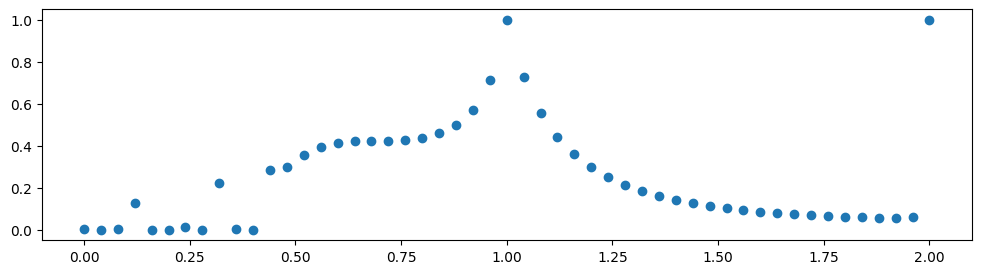

In [121]:
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

r_squares = []
d_domain = np.linspace(0, 2, 51)
for d in d_domain:
    res = frac_diff_ffd(pd.DataFrame({'cum_series': cum_series}), d=d, tau=1e-5)
    ffd_res = res['cum_series'].values
    ffd_x = x[-len(ffd_res):]

    params, _ = curve_fit(sine_function, ffd_x, ffd_res)
    fitted_values = sine_function(ffd_x, *params)
    r_squared_original = r2_score(ffd_res, fitted_values)
    r_squares.append(r_squared_original)

print(f'Max R-squared for cumulative series with FFD(d={d_domain[np.argmax(r_squares)]}) = {np.max(r_squares)}')
plt.figure(figsize=(12, 3))
plt.scatter(d_domain, r_squares)

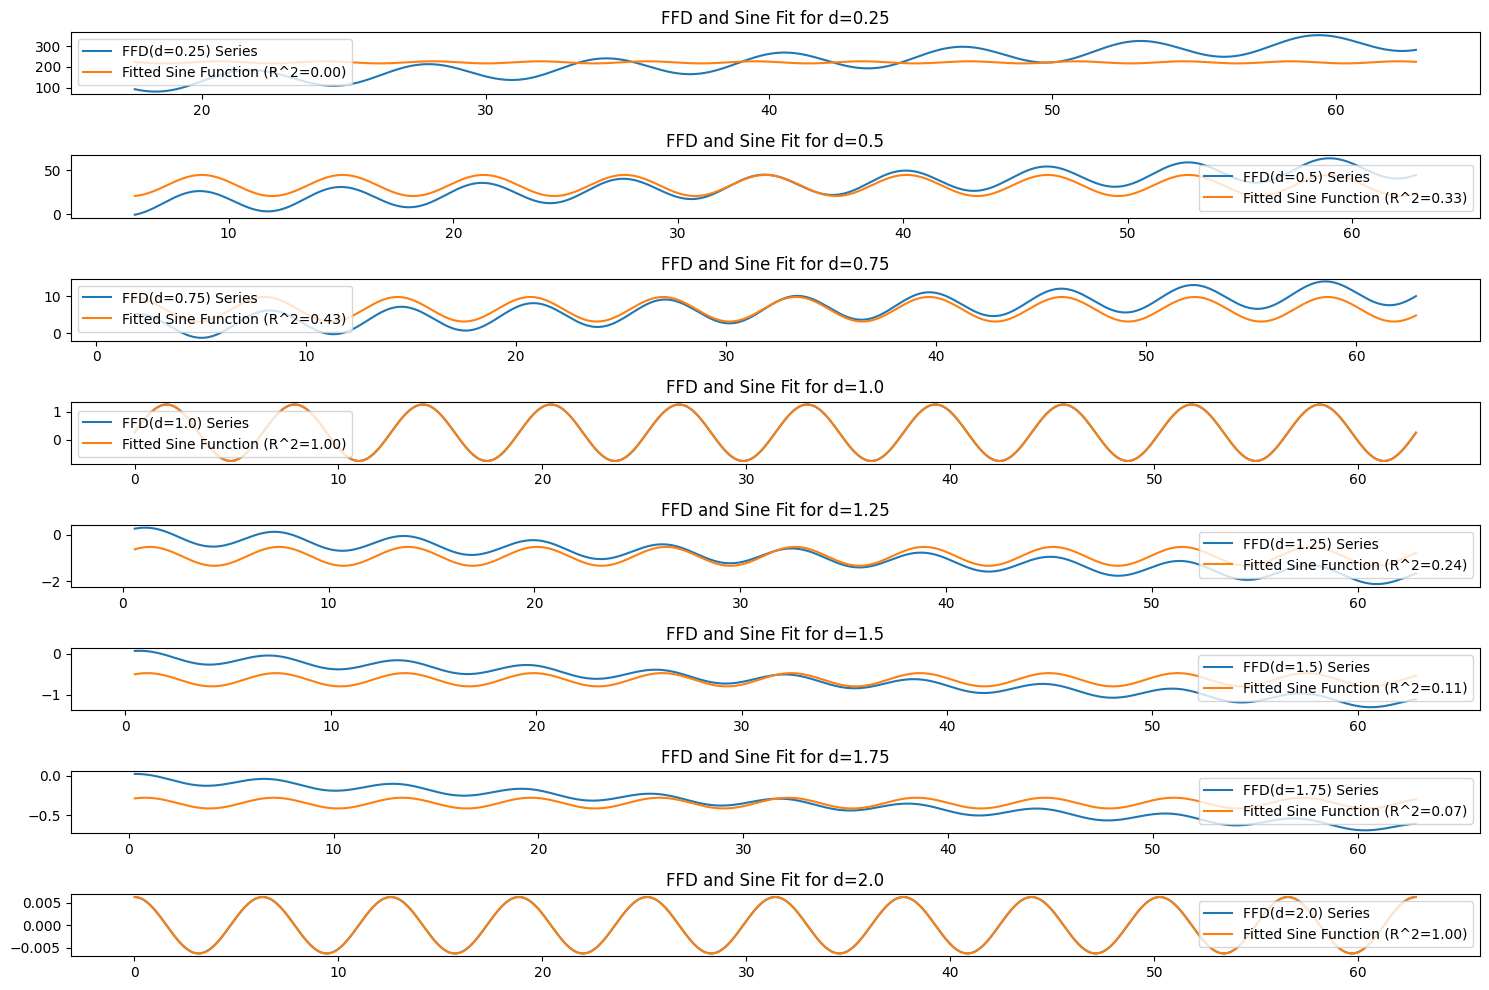

In [122]:
def visualize_ffd_and_fit(d_values, original_series):
    plt.figure(figsize=(15, 10))

    for d in d_values:
        ffd_series = frac_diff_ffd(pd.DataFrame({'original_series': original_series}), d, tau=1e-5)
        ffd_series = ffd_series['original_series'].dropna().values
        x_values = x[-len(ffd_series):]

        params_ffd, _ = curve_fit(sine_function, x_values, ffd_series)
        fitted_values_ffd = sine_function(x_values, *params_ffd)
        r_squared_ffd = r2_score(ffd_series, fitted_values_ffd)

        plt.subplot(len(d_values), 1, d_values.index(d) + 1)
        plt.plot(x_values, ffd_series, label=f'FFD(d={d}) Series')
        plt.plot(x_values, fitted_values_ffd, label=f'Fitted Sine Function (R^2={r_squared_ffd:.2f})')
        plt.legend()
        plt.title(f'FFD and Sine Fit for d={d}')

    plt.tight_layout()
    plt.show()


# Apply visualization
d_values_to_visualize = list(np.arange(0.25, 2.01, 0.25))
visualize_ffd_and_fit(d_values_to_visualize, cum_series)


### 5.4 Take the dollar bar series on E-mini S&P 500 futures. Using the code in Snippet 5.3, for some d ∈ [0, 2], compute fracDiff_FFD(fracDiff_FFD(series,d),-d). What do you get? Why?

In [2]:
btc_dollar = pd.read_parquet('../data/dollar-bars-100000000-True.parquet')
btc_dollar = btc_dollar[btc_dollar.index > pd.Timestamp('2023-01-01').timestamp() * 1000]
btc_dollar = btc_dollar.iloc[:-2]

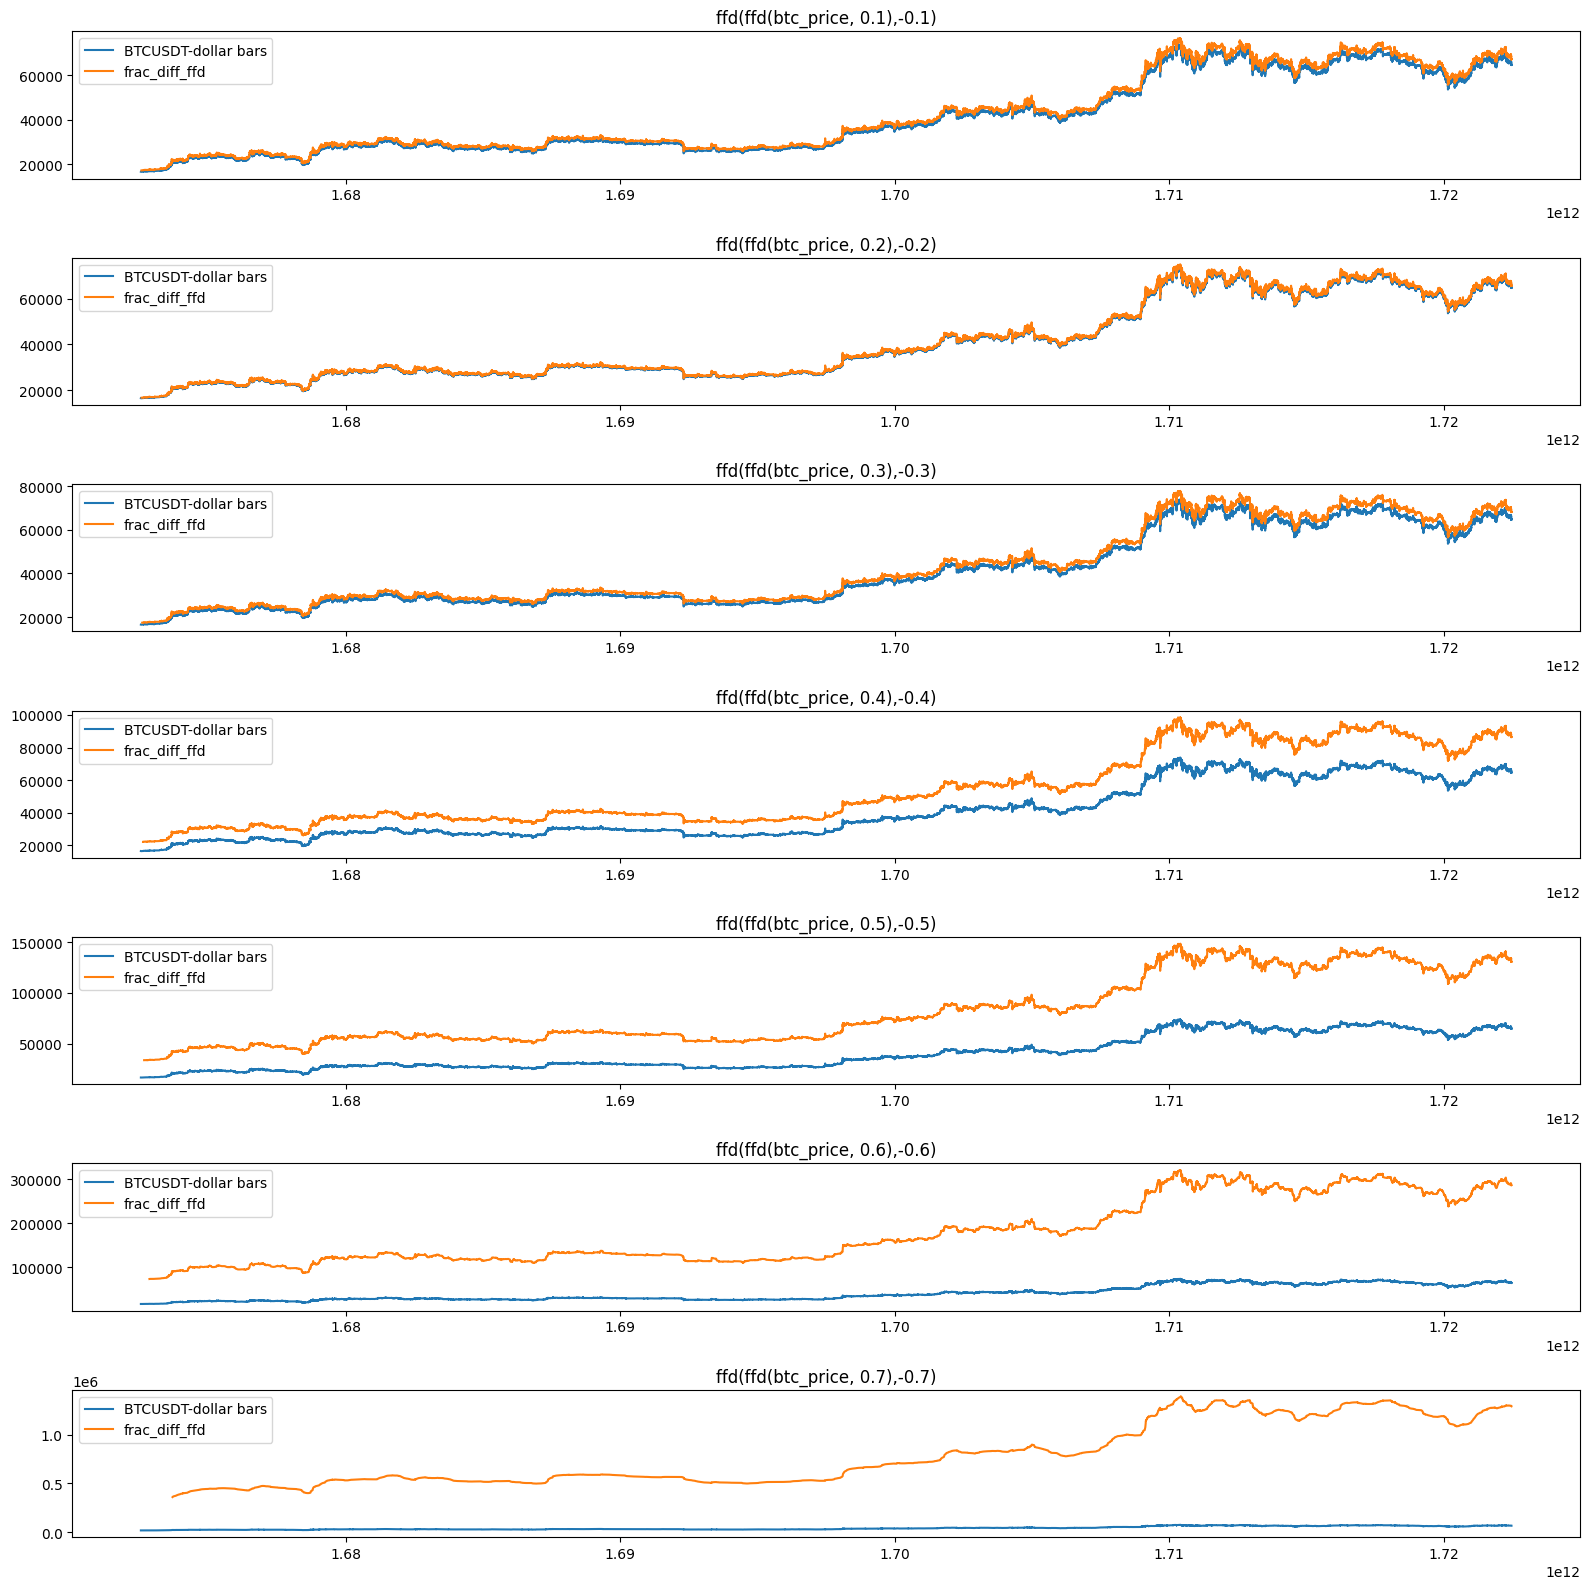

In [3]:
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

d_domains = np.arange(0.1, 0.8, 0.1)
fig, axes = plt.subplots(len(d_domains), 1, figsize=(16, 16))
for ax, d in zip(axes, d_domains):
    res = frac_diff_ffd(frac_diff_ffd(btc_dollar[['close']], d, tau=0.1), -d, tau=0.1)
    ax.plot(btc_dollar['close'], label='BTCUSDT-dollar bars')
    ax.plot(res, label='frac_diff_ffd')
    ax.set_title(f'ffd(ffd(btc_price, {d:.1f}),-{d:.1f})')
    ax.legend()

plt.tight_layout()
plt.show()


Because we take ffd(ffd(series, d), -d), and we requested do use d ∈ [0, 2]
When d < 1 the weights are decreasing, on cases where 0.7 < d < 1 the decrease if of the weights is very slow and may cause memory error.
When d == 1 the weights are constant 1 so it actually the sum of the weights.
When d > 1 the weights are growing makes the older the price the heavier weight it gets.

I show on these plots only when d ∈ [0, 0.7], the smaller d the "better" reconstructions, even though ffd^-1(d) != ffd(-d).


### 5.5 Take the dollar bar series on E-mini S&P 500 futures.

#### 5.5 (a) Form a new series as a cumulative sum of log-prices.

In [3]:
cum_log_prices = np.log(btc_dollar['close']).cumsum()

#### 5.5 (b) Apply FFD, with $\tau$ = 1E − 5. Determine for what minimum d ∈ [0, 2] the new series is stationary.

  0%|          | 0/21 [00:00<?, ?it/s]

Minimum d with that makes frac_diff_ffd result stationary is 2.0


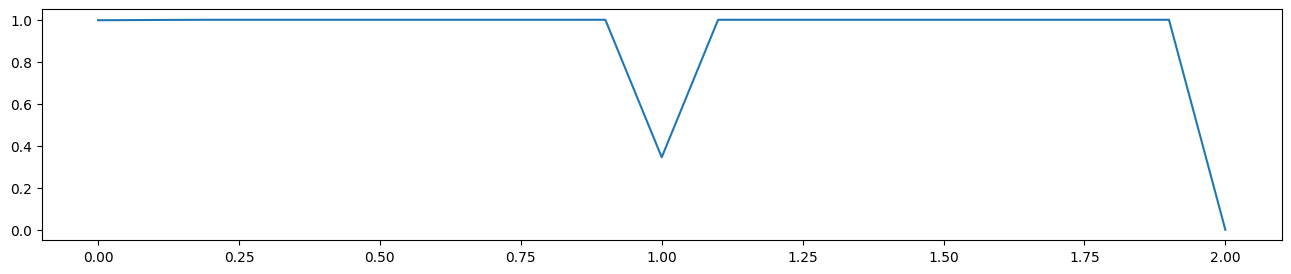

In [11]:
import time
from tqdm.notebook import tqdm
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

p_values = []
is_stationary = []
d_domains = np.arange(0, 2.1, 0.1)
for d in tqdm(d_domains):
    t1 = time.time()
    res = frac_diff_ffd(pd.DataFrame(cum_log_prices), d, tau=1e-5)
    adf_result = adfuller(res['close'].values)
    p_values.append(adf_result[1])
    is_stationary.append(adf_result[1] < 0.05)

if any(is_stationary):
    print(f'Minimum d with that makes frac_diff_ffd result stationary is {d_domains[np.argmax(is_stationary)]}')
else:
    print(
        f"wasn't any d that makes the result from frac_diff_ffd stationary, even though the best d was {min(p_values)} with {d_domains[np.argmin(p_values)]}")

plt.figure(figsize=(16, 3))
plt.plot(d_domains, p_values)

Stationary gets only on 2 because its the cumsum of the prices!
For comparison, here is ffd for the log prices 

  0%|          | 0/21 [00:00<?, ?it/s]

Minimum d with that makes frac_diff_ffd result stationary is 0.4


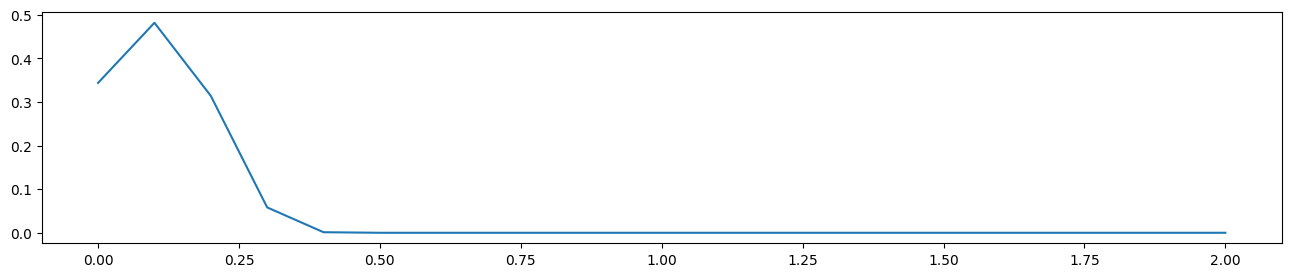

In [6]:
import time
from tqdm.notebook import tqdm

p_values = []
is_stationary = []
d_domains = np.arange(0, 2.1, 0.1)
for d in tqdm(d_domains):
    t1 = time.time()
    res = frac_diff_ffd(pd.DataFrame(np.log(btc_dollar['close'])), d, tau=1e-5)
    adf_result = adfuller(res['close'].values)
    p_values.append(adf_result[1])
    is_stationary.append(adf_result[1] < 0.05)

if any(is_stationary):
    print(f'Minimum d with that makes frac_diff_ffd result stationary is {d_domains[np.argmax(is_stationary)]}')
else:
    print(
        f"wasn't any d that makes the result from frac_diff_ffd stationary, even though the best d was {min(p_values)} with {d_domains[np.argmin(p_values)]}")

plt.figure(figsize=(16, 3))
plt.plot(d_domains, p_values)

#### 5.5 (c) Compute the correlation of the fracdiff series to the original (untransformed) series

In [4]:
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

fracdiff_series = frac_diff_ffd(pd.DataFrame(np.log(btc_dollar['close']).cumsum()), 2, tau=1e-5)
np.corrcoef(btc_dollar.loc[fracdiff_series.index, 'close'], fracdiff_series['close'])[0, 1]

np.float64(-0.0011033480819937522)

#### 5.5 (d) Apply an Engel-Granger cointegration test on the original and fracdiff series. Are they cointegrated? Why?

In [6]:
from statsmodels.tsa.stattools import coint

# Perform the Engel-Granger cointegration test
coint_t, p_value, critical_values = coint(btc_dollar.loc[fracdiff_series.index, 'close'], fracdiff_series['close'])

print(f"Cointegration Test t-statistic: {coint_t}")
print(f"Cointegration Test p-value: {p_value}")
print(f"Critical Values: {critical_values}")

Cointegration Test t-statistic: -1.121347113309025
Cointegration Test p-value: 0.8773121648216538
Critical Values: [-3.89657995 -3.33620808 -3.0445042 ]


They are not cointgarated because we did fracdiff on the cumsum(log(prices))

### 5.5 (d) Apply a Jarque-Bera normality test on the fracdiff series.

In [9]:
from scipy.stats import jarque_bera

jb_stat, jb_p_value = jarque_bera(fracdiff_series)
print(f"Jarque-Bera Test Statistic: {jb_stat}")
print(f"Jarque-Bera Test p-value: {jb_p_value}")

Jarque-Bera Test Statistic: 11399.598150379647
Jarque-Bera Test p-value: 0.0


the fracdiff_series is stationary

### 5.6 Take the fracdiff series from exercise 5.

#### 5.6 (a) Apply a CUSUM filter (Chapter 2), where h is twice the standard deviation of the series.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from afml.data_analyst.fractionally_differentiated_features import frac_diff_ffd

btc_dollar = pd.read_parquet('../data/dollar-bars-100000000-True.parquet')
btc_dollar = btc_dollar[btc_dollar.index > pd.Timestamp('2023-01-01').timestamp() * 1000]
btc_dollar = btc_dollar.iloc[:-2]

cum_log_prices = np.log(btc_dollar['close']).cumsum()
fracdiff_series = frac_diff_ffd(pd.DataFrame(np.log(btc_dollar['close']).cumsum()), 2, tau=1e-5)
np.corrcoef(btc_dollar.loc[fracdiff_series.index, 'close'], fracdiff_series['close'])[0, 1]

np.float64(-0.0011033480819937522)

In [2]:
from afml.data_analyst.financial_data_structures import get_t_events
import plotly.graph_objects as go


def scatter_events_on_plot(bars: pd.DataFrame, events: np.ndarray, events_title: str):
    open_time = pd.to_datetime(bars.index, unit='ms')
    fig = go.Figure(
        data=[go.Scatter(x=open_time, y=bars['close'], line=dict(color="blue", width=1), name='price')]
    ).update_layout(xaxis_title="Time", yaxis_title="Price", title="Dollar Bars")
    event_time = pd.to_datetime(events, unit='ms')
    fig.add_trace(go.Scatter(x=event_time, y=bars[bars.index.isin(events)]['close'], mode='markers', name=events_title))
    fig.show()


t0 = get_t_events(fracdiff_series.index.values, fracdiff_series['close'].values,
                  float(4 * np.std(fracdiff_series.values)))
# scatter_events_on_plot(fracdiff_series, t0, events_title='cumsum filter')

#### 5.6 (b) Use the filtered timestamps to sample a features’ matrix. Use as one of the features the fracdiff value.

In [3]:
from afml.data_analyst.labels import get_events_triple_barrier, get_daily_vol, get_vertical_next_day, get_bins

dayly_vol = get_daily_vol(btc_dollar)
feat_mat = pd.DataFrame(fracdiff_series)

#### 5.6 (c) Form labels using the triple-barrier method, with symmetric horizontal barriers of twice the daily standard deviation, and a vertical barrier of 5 days.

In [4]:
ms_a_day = 24 * 60 * 60 * 1000
num_days = 5
t1 = get_vertical_next_day(btc_dollar, t0, num_days * ms_a_day)

events = get_events_triple_barrier(
    close=btc_dollar.loc[fracdiff_series.index, 'close'],
    t0=t0,
    tp_scale=2,
    sl_scale=2,
    target=dayly_vol,
    min_return=0,
    t1=t1,
)
labels = get_bins(events, btc_dollar['close'], t1)
labels.head()

,ret,bin
1.673219e+12,0.010723,1.0
1.673219e+12,0.009777,1.0
1.673272e+12,0.015783,1.0
1.673479e+12,0.014426,1.0
1.673480e+12,0.013807,1.0


#### 5.6 (d) Fit a bagging classifier of decision trees where:
1. The observed features are bootstrapped using the sequential method
from Chapter 4.
2. On each bootstrapped sample, sample weights are determined using the
techniques from Chapter 4.

In [5]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame({
    'close': fracdiff_series['close'].loc[labels.index],
    'close_lag_1': fracdiff_series['close'].shift(1).loc[labels.index],
    'close_lag_2': fracdiff_series['close'].shift(2).loc[labels.index],
},
    index=labels.index
)

X_train, X_test, y_train, y_test = train_test_split(X, labels['bin'], test_size=0.3,
                                                    shuffle=False,
                                                    random_state=42)

t1_train = t1[t1.index < X_test.index[0]]

In [9]:
from sklearn.ensemble import _bagging
from afml.data_analyst.sample_weights import get_ind_matrix, bagging_seq_bootstrap

index_matrix = get_ind_matrix(X_train.index, t1_train)
bootstrap_callback = bagging_seq_bootstrap(index_matrix)
def seq_bootstrap_generate_bagging_indices(
    random_state,
    bootstrap_features,
    bootstrap_samples,
    n_features,
    n_samples,
    max_features,
    max_samples,
):
    """Randomly draw feature and sample indices."""
    # Get valid random state
    random_state = _bagging.check_random_state(random_state)

    # Draw indices
    feature_indices = _bagging._generate_indices(
        random_state, bootstrap_features, n_features, max_features
    )
    if bootstrap_samples:
        sample_indices = bootstrap_callback(max_samples)
    else:
        sample_indices = _bagging.sample_without_replacement(
            n_samples, n_samples, random_state=random_state
        )

    return feature_indices, sample_indices


# the bagging bootstrap is not configurable in a traditional way to give a callback of sampler so i had to modify it with my custom sampler
original_begging_indices = _bagging._generate_bagging_indices

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_decision_tree = DecisionTreeClassifier(
    criterion='entropy',
    max_features='log2',
    class_weight='balanced',  # type: ignore
)

classifier_w_bootstrap = BaggingClassifier(
    estimator=base_decision_tree,
    n_estimators=100,
    bootstrap=True,
    random_state=42,
    max_samples=int(np.sqrt(len(X_train)))
)

classifier_wo_bootstrap = BaggingClassifier(
    estimator=base_decision_tree,
    n_estimators=100,
    random_state=42,
    max_samples=int(np.sqrt(len(X_train)))
)


In [11]:
from sklearn import metrics
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

_bagging._generate_bagging_indices = seq_bootstrap_generate_bagging_indices
classifier_w_bootstrap.fit(
    X_train,
    y_train
)

_bagging._generate_bagging_indices = original_begging_indices
classifier_wo_bootstrap.fit(
    X_train,
    y_train,
)

print('No weights')
print('Without bootstrap')
print(metrics.classification_report(y_test, classifier_wo_bootstrap.predict(X_test)))
print('With bootstrap')
print(metrics.classification_report(y_test, classifier_w_bootstrap.predict(X_test)))

No weights
Without bootstrap
              precision    recall  f1-score   support

        -1.0       0.50      0.01      0.02       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      1.00      0.71       479

    accuracy                           0.55       866
   macro avg       0.35      0.33      0.24       866
weighted avg       0.51      0.55      0.40       866

With bootstrap
              precision    recall  f1-score   support

        -1.0       0.57      0.01      0.02       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      0.99      0.71       479

    accuracy                           0.55       866
   macro avg       0.38      0.33      0.24       866
weighted avg       0.54      0.55      0.40       866


Different methods of weights

In [13]:
import importlib
from afml.data_analyst import sample_weights
importlib.reload(sample_weights)
from afml.data_analyst.sample_weights import num_co_events, sample_w_by_uniqueness

co_events = num_co_events(X_train.index, t1_train)
w_uniqueness = sample_w_by_uniqueness(
        t1=t1_train,
        co_events=co_events,
    )

_bagging._generate_bagging_indices = seq_bootstrap_generate_bagging_indices
classifier_w_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=w_uniqueness,
)

_bagging._generate_bagging_indices = original_begging_indices
classifier_wo_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=w_uniqueness,
)

print('Uniqueness weights')
print('Without bootstrap')
print(metrics.classification_report(y_test, classifier_wo_bootstrap.predict(X_test)))
print('With bootstrap')
print(metrics.classification_report(y_test, classifier_w_bootstrap.predict(X_test)))

Uniqness weights
Without bootstrap
              precision    recall  f1-score   support

        -1.0       0.50      0.04      0.08       358
         0.0       0.00      0.00      0.00        29
         1.0       0.56      0.97      0.71       479

    accuracy                           0.56       866
   macro avg       0.35      0.34      0.26       866
weighted avg       0.52      0.56      0.42       866

With bootstrap
              precision    recall  f1-score   support

        -1.0       0.40      0.03      0.06       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      0.96      0.70       479

    accuracy                           0.55       866
   macro avg       0.32      0.33      0.25       866
weighted avg       0.47      0.55      0.41       866


In [15]:
from afml.data_analyst.sample_weights import sample_w_by_return

w_return = sample_w_by_return(
        t1=t1_train,
        co_events=num_co_events(X_train.index, t1_train),
        close=btc_dollar['close']
    )

_bagging._generate_bagging_indices = seq_bootstrap_generate_bagging_indices
classifier_w_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=w_return,
)

_bagging._generate_bagging_indices = original_begging_indices
classifier_wo_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=w_return,
)

print('Returns weights')
print('Without bootstrap')
print(metrics.classification_report(y_test, classifier_wo_bootstrap.predict(X_test)))
print('With bootstrap')
print(metrics.classification_report(y_test, classifier_w_bootstrap.predict(X_test)))


Returns weights
Without bootstrap
              precision    recall  f1-score   support

        -1.0       1.00      0.01      0.01       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      1.00      0.71       479

    accuracy                           0.56       866
   macro avg       0.52      0.34      0.24       866
weighted avg       0.72      0.56      0.40       866

With bootstrap
              precision    recall  f1-score   support

        -1.0       0.36      0.03      0.05       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      0.97      0.70       479

    accuracy                           0.55       866
   macro avg       0.30      0.33      0.25       866
weighted avg       0.45      0.55      0.41       866


In [16]:
from afml.data_analyst.sample_weights import linear_time_decay
linear_decay_w_return = linear_time_decay(w_return)

_bagging._generate_bagging_indices = seq_bootstrap_generate_bagging_indices
classifier_w_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=linear_decay_w_return,
)

_bagging._generate_bagging_indices = original_begging_indices
classifier_wo_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=linear_decay_w_return,
)

print('Linear time decay returns weights')
print('Without bootstrap')
print(metrics.classification_report(y_test, classifier_wo_bootstrap.predict(X_test)))
print('With bootstrap')
print(metrics.classification_report(y_test, classifier_w_bootstrap.predict(X_test)))

Linear time decay returns weights
Without bootstrap
              precision    recall  f1-score   support

        -1.0       0.46      0.05      0.10       358
         0.0       0.00      0.00      0.00        29
         1.0       0.56      0.96      0.70       479

    accuracy                           0.55       866
   macro avg       0.34      0.34      0.27       866
weighted avg       0.50      0.55      0.43       866

With bootstrap
              precision    recall  f1-score   support

        -1.0       0.33      0.03      0.06       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      0.95      0.70       479

    accuracy                           0.54       866
   macro avg       0.29      0.33      0.25       866
weighted avg       0.44      0.54      0.41       866


In [17]:
from afml.data_analyst.sample_weights import exponential_time_decay
exponential_decay_w_return = exponential_time_decay(w_return)

_bagging._generate_bagging_indices = seq_bootstrap_generate_bagging_indices
classifier_w_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=exponential_decay_w_return,
)

_bagging._generate_bagging_indices = original_begging_indices
classifier_wo_bootstrap.fit(
    X_train,
    y_train,
    sample_weight=exponential_decay_w_return,
)

print('Exponential time decay returns weights')
print('Without bootstrap')
print(metrics.classification_report(y_test, classifier_wo_bootstrap.predict(X_test)))
print('With bootstrap')
print(metrics.classification_report(y_test, classifier_w_bootstrap.predict(X_test)))

Exponential time decay returns weights
Without bootstrap
              precision    recall  f1-score   support

        -1.0       0.60      0.02      0.03       358
         0.0       0.00      0.00      0.00        29
         1.0       0.55      0.99      0.71       479

    accuracy                           0.56       866
   macro avg       0.38      0.34      0.25       866
weighted avg       0.55      0.56      0.41       866

With bootstrap
              precision    recall  f1-score   support

        -1.0       0.64      0.05      0.09       358
         0.0       0.00      0.00      0.00        29
         1.0       0.56      0.98      0.71       479

    accuracy                           0.56       866
   macro avg       0.40      0.34      0.27       866
weighted avg       0.58      0.56      0.43       866


All of the models shows poor performance because the provided data is limited and not provided anything special, even though we can see a slight differences between the results, the best performance was actually without bootstrap and the sample weighted by uniqueness, but still when i will try a true model with real features i still will try these techniques.